### Immobilienrechner - Explorative Datenanalyse

[Immobilienrechner - Main](./immo_main.ipynb)<br>
[Immobilienrechner - Webscraper](./immo_scrap.ipynb)<br>
[Immobilienrechner - Modellentwicklung](./immo_model.ipynb)<br>
[Immobilienrechner - Bereitstellung des besten Preisvorhersagemodells per Webinterface](./flask/immo_flask.ipynb)

In [87]:
import numpy as np
import pandas as pd
import os
import sys
from random import randint
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Allgemeine Informationen zu den gesammelten Datensätzen.

In [88]:
df = pd.read_csv('eka.csv')
print('Datensätze: ',df.shape[0])
print(df.info())
df.describe()

Datensätze:  1255
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   plz        1255 non-null   int64  
 1   stadtteil  1255 non-null   object 
 2   preis      1251 non-null   float64
 3   groesse    1249 non-null   float64
 4   zimmer     1249 non-null   float64
 5   a_name     1255 non-null   object 
 6   link       1255 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 68.8+ KB
None


,plz,preis,groesse,zimmer
count,1255.000000,1.251000e+03,1249.000000,1249.000000
mean,11999.308367,5.811940e+05,82.803955,2.731785
std,1366.650050,5.608480e+05,45.102938,1.690411
min,10115.000000,6.900000e+04,18.000000,1.000000
25%,10629.000000,2.705500e+05,55.790000,2.000000
50%,12157.000000,3.950000e+05,72.000000,3.000000
75%,13349.000000,6.790000e+05,98.490000,3.000000
max,14199.000000,8.500000e+06,550.000000,44.000000


Datensätze, deren Features Nans enthalten, identifizieren und entfernen.

In [89]:
mit_nans = df[df['preis'].isna() | df['groesse'].isna() | df['zimmer'].isna()]

print('Datensätze mit Nans:', mit_nans.shape[0])
print(mit_nans[['preis', 'groesse', 'zimmer']])

cond = df['link'].isin(mit_nans['link'])
df.drop(df[cond].index, inplace = True)
print('\nDatensätze: ', df.shape[0])

Datensätze mit Nans: 10
         preis  groesse  zimmer
287   380000.0      NaN     NaN
357        NaN    92.00     4.0
479   276000.0      NaN     NaN
552   441000.0      NaN     NaN
703   220000.0      NaN     NaN
704   179000.0      NaN     NaN
710        NaN    48.37     2.0
851   320000.0      NaN     NaN
1131       NaN    92.00     4.0
1207       NaN   180.00     5.0

Datensätze:  1245


Datentypen umwandeln und grobe Ausreißer entfernen

In [90]:
df.preis = df.preis.astype(int)

df.drop(df[(df.preis < 100_000)|(df.preis > 6_500_000)].index,
        inplace=True)
df.drop(df[df.zimmer > 10].index,
        inplace=True)
df.drop(df[df.groesse > 220].index,
        inplace=True)
print('Datensätze nach grober Säuberung:', df.shape[0])

df.describe()

Datensätze nach grober Säuberung: 1221


,plz,preis,groesse,zimmer
count,1221.000000,1.221000e+03,1221.000000,1221.000000
mean,12018.744472,5.465201e+05,79.174570,2.631040
std,1365.665564,4.346129e+05,33.496997,1.046671
min,10115.000000,1.150000e+05,18.000000,1.000000
25%,10629.000000,2.700000e+05,55.340000,2.000000
50%,12159.000000,3.950000e+05,71.620000,2.500000
75%,13349.000000,6.500000e+05,96.730000,3.000000
max,14199.000000,3.650000e+06,213.800000,7.000000


Ausreißer behandeln, per Quantil-Methode oder durch manuelle Anpassung 

In [91]:
# quantil-methode zur abstandsbestimmung
og_zimmer = df.zimmer.quantile(.9)
og_groesse = df.groesse.quantile(.9)
og_preis = df.preis.quantile(.9)

ug_zimmer = df.zimmer.quantile(.1)
ug_groesse = df.groesse.quantile(.1)
ug_preis = df.preis.quantile(.1)

print(f'Quantile: Obergrenzen: Zimmer:{og_zimmer} Groesse:{og_groesse} Preis:{og_preis}')
print(f'Quantile: Untergrenzen: Zimmer:{ug_zimmer} Groesse:{ug_groesse} Preis:{ug_preis}')

df_quant = df.copy()
og_zimmer = 5
df_quant.drop(df_quant[(df_quant.zimmer < ug_zimmer)|(df_quant.zimmer > og_zimmer)].index, inplace=True)
print(f'Quantile: Zimmer gedroppt:{len(df)-len(df_quant)}')

old=len(df_quant)
df_quant.drop(df_quant[(df_quant.groesse < ug_groesse)|(df_quant.groesse > og_groesse)].index, inplace=True)
print(f'Quantile: Groesse gedroppt:{old-len(df_quant)}')

old=len(df_quant)
df_quant.drop(df_quant[(df_quant.preis < ug_preis)|(df_quant.preis > og_preis)].index, inplace=True)
print(f'Quantile: Preis gedroppt:{len(df)-len(df_quant)}')

print(f'Quantile: Benutzte Grenzeinstellungen og_zimmer:{og_zimmer} ug_zimmer:{ug_zimmer}\
 og_groesse:{og_groesse} ug_groesse:{ug_groesse} og_preis:{og_preis} ug_preis:{ug_preis}')


# manuelle abstandsbestimmung
df_man = df.copy()

q3_zimmer = df.zimmer.median() + df.zimmer.std()
print('manuelle og zimmer:',q3_zimmer,'std:',df.zimmer.std())
q1_zimmer = df.zimmer.median() - df.zimmer.std()
print('manuelle ug zimmer:',q1_zimmer,'std:',df.zimmer.std())

q3_groesse = df.groesse.median() + df.groesse.std()
print('manuelle og groesse:',q3_groesse,'std:',df.groesse.std())
q1_groesse = df.groesse.median() - df.groesse.std()
print('manuelle ug groesse:',q1_groesse,'std:',df.groesse.std())

q3_preis = df.preis.median() + df.preis.std()
print('manuelle og preis:',q3_preis,'std:',df.preis.std())
q1_preis = df.preis.median() - df.preis.std()
print('manuelle ug preis:',q1_preis,'std:',df.preis.std())

q3_zimmer = 5
df_man.drop(df_man[(df_man.zimmer < q1_zimmer)|(df_man.zimmer > q3_zimmer)].index, inplace=True)
print(f'Manuell: Zimmer gedroppt:{len(df)-len(df_man)}')

old=len(df_man)
q3_groesse = 120
q1_groesse = 45
df_man.drop(df_man[(df_man.groesse < q1_groesse)|(df_man.groesse > q3_groesse)].index, inplace=True)
print(f'Manuell: Groesse gedroppt:{old-len(df_man)}')

old=len(df_man)
q1_preis = 200_000
q3_preis = 1_000_000
df_man.drop(df_man[(df_man.preis < q1_preis)|(df_man.preis > q3_preis)].index, inplace=True)
print(f'Manuell: Preis gedroppt:{old-len(df_man)}')
print(f'Manuell: Benutzte Grenzeinstellungen og_zimmer:{q3_zimmer} ug_zimmer:{q1_zimmer}\
 og_groesse:{q3_groesse} ug_groesse:{q1_groesse} og_preis:{q3_preis} ug_preis:{q1_preis}')

print('Datensaetze von df_man:', len(df_man))
print('Datensaetze von df_quant:', len(df_quant))

Quantile: Obergrenzen: Zimmer:4.0 Groesse:127.0 Preis:1100000.0
Quantile: Untergrenzen: Zimmer:1.0 Groesse:42.52 Preis:199900.0
Quantile: Zimmer gedroppt:14
Quantile: Groesse gedroppt:231
Quantile: Preis gedroppt:352
Quantile: Benutzte Grenzeinstellungen og_zimmer:5 ug_zimmer:1.0 og_groesse:127.0 ug_groesse:42.52 og_preis:1100000.0 ug_preis:199900.0
manuelle og zimmer: 3.546670591483636 std: 1.0466705914836358
manuelle ug zimmer: 1.4533294085163642 std: 1.0466705914836358
manuelle og groesse: 105.11699735380334 std: 33.49699735380334
manuelle ug groesse: 38.12300264619667 std: 33.49699735380334
manuelle og preis: 829612.880109987 std: 434612.88010998705
manuelle ug preis: -39612.88010998705 std: 434612.88010998705
Manuell: Zimmer gedroppt:154
Manuell: Groesse gedroppt:166
Manuell: Preis gedroppt:115
Manuell: Benutzte Grenzeinstellungen og_zimmer:5 ug_zimmer:1.4533294085163642 og_groesse:120 ug_groesse:45 og_preis:1000000 ug_preis:200000
Datensaetze von df_man: 786
Datensaetze von df_qu

#### Informationen zu einzelnen Stadtteilbezirken
Aggretierte Werte für Preis, Wohnungsgröße und Zimmeranzahl pro Berliner Stadtbezirk.

In [92]:
grps_man.size()

stadtteil
Biesdorf              2
Blankenfelde          1
Buch                  1
Buckow                1
Charlottenburg       49
Dahlem                9
Französisch           4
Friedenau            14
Friedrichsfelde       6
Friedrichshain       40
Gesundbrunnen         7
Grunewald             2
Heiligensee           1
Heinersdorf           3
Hellersdorf           3
Hohenschönhausen      5
Karlshorst            9
Kreuzberg            17
Köpenick             45
Lichtenberg          17
Lichterfelde         16
Marzahn               2
Mitte                35
Moabit                2
Neukölln             45
Niederschönhausen     2
Pankow               24
Prenzlauer           32
Reinickendorf        42
Rosenthal             1
Rudow                 1
Rummelsburg           1
Schöneberg           28
Spandau              39
Steglitz             44
Tegel                 1
Tempelhof            40
Tiergarten           31
Treptow              20
Wedding              27
Weissensee            9
Westen

In [93]:
grps_man = df_man.groupby('stadtteil')
grps_man.aggregate(np.mean)[['preis', 'groesse', 'zimmer']]

,preis,groesse,zimmer
stadtteil,,,
Biesdorf,448000.000000,69.590000,2.000000
Blankenfelde,479000.000000,68.640000,2.000000
Buch,245000.000000,70.000000,3.000000
Buckow,339000.000000,50.350000,2.000000
Charlottenburg,457704.081633,72.632653,2.540816
Dahlem,720455.555556,83.112222,2.833333
Französisch,463249.750000,79.357500,2.750000
Friedenau,480664.285714,86.604286,2.821429
Friedrichsfelde,279612.333333,60.430000,2.166667


In [94]:
grps_man.aggregate(np.max)[['preis', 'groesse', 'zimmer']]

,preis,groesse,zimmer
stadtteil,,,
Biesdorf,540000,74.18,2.0
Blankenfelde,479000,68.64,2.0
Buch,245000,70.00,3.0
Buckow,339000,50.35,2.0
Charlottenburg,984000,120.00,4.0
Dahlem,995000,120.00,4.5
Französisch,699999,99.96,3.0
Friedenau,680000,112.75,4.0
Friedrichsfelde,425000,83.00,3.0


In [95]:
grps_man.aggregate(np.std)[['preis', 'groesse', 'zimmer']]

,preis,groesse,zimmer
stadtteil,,,
Biesdorf,130107.647738,6.491240,0.000000
Blankenfelde,NaN,NaN,NaN
Buch,NaN,NaN,NaN
Buckow,NaN,NaN,NaN
Charlottenburg,225252.090380,17.170070,0.660151
Dahlem,296823.963449,26.591096,0.790569
Französisch,165925.963912,15.253931,0.500000
Friedenau,95429.735385,11.879510,0.607870
Friedrichsfelde,81499.653282,12.298836,0.408248


### Datenvisualisierung

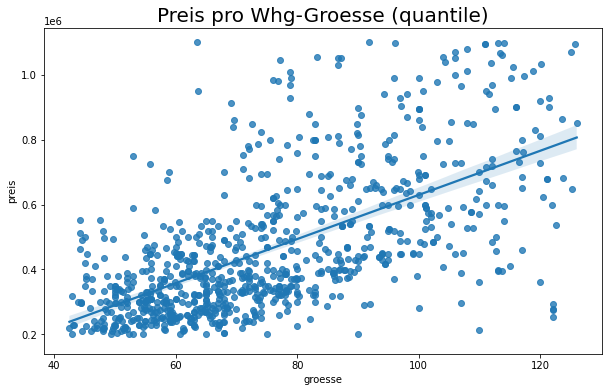

In [96]:
plt.figure(figsize=(10,6))
sns.regplot(x='groesse',y='preis',data=df_quant)
plt.ylim(df_quant.preis.min()*.7,)
plt.title('Preis pro Whg-Groesse (quantile)',fontsize=20)
plt.show()

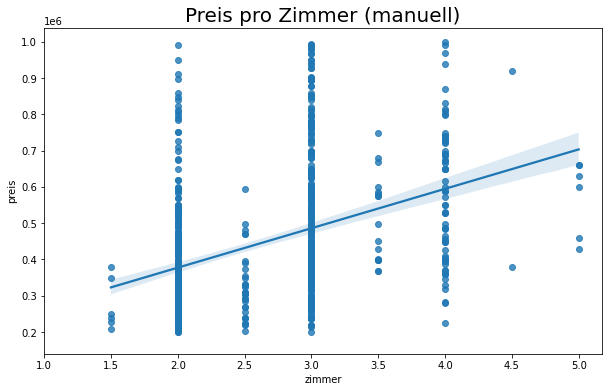

In [97]:
plt.figure(figsize=(10,6))
sns.regplot(x='zimmer',y='preis',data=df_man)
plt.ylim(2,)
plt.xlim(1,)
plt.title('Preis pro Zimmer (manuell)',fontsize=20)
plt.ylim(df_man.preis.min()*.7,)
plt.xlim(df_man.zimmer.min()-.5,)
plt.show()

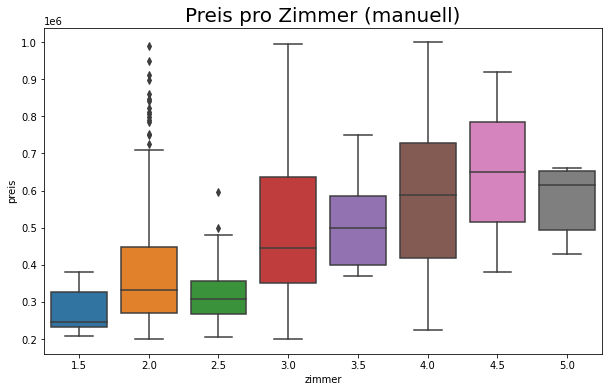

In [98]:
plt.figure(figsize=(10,6))
sns.boxplot(x='zimmer',y='preis',data=df_man)
plt.title('Preis pro Zimmer (manuell)',fontsize=20)
plt.show()

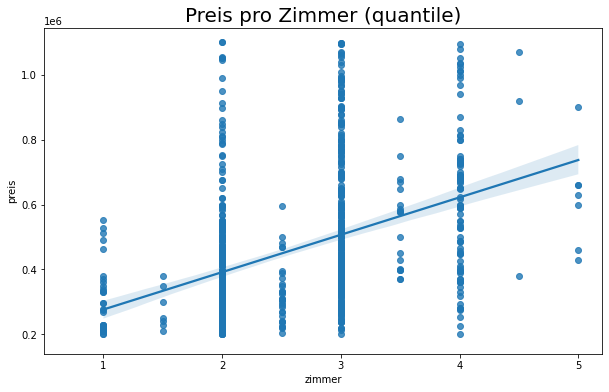

In [99]:
plt.figure(figsize=(10,6))
sns.regplot(x='zimmer',y='preis',data=df_quant)
plt.ylim(2,)
plt.xlim(1,)
plt.title('Preis pro Zimmer (quantile)',fontsize=20)
plt.ylim(df_quant.preis.min()*.7,)
plt.xlim(df_quant.zimmer.min()-.5,)
plt.show()

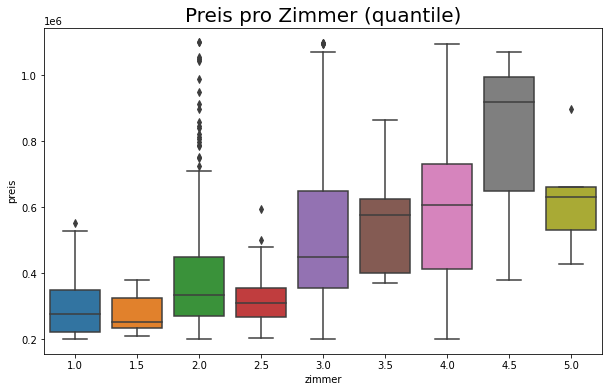

In [100]:
plt.figure(figsize=(10,6))
sns.boxplot(x='zimmer',y='preis',data=df_quant)
plt.title('Preis pro Zimmer (quantile)',fontsize=20)
plt.show()

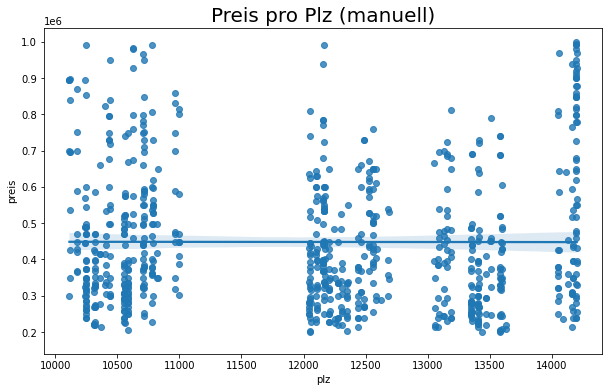

In [101]:
plt.figure(figsize=(10,6))
sns.regplot(x='plz',y='preis',data=df_man)
plt.ylim(df_man.preis.min()*.7,)
plt.title('Preis pro Plz (manuell)',fontsize=20)
plt.show()

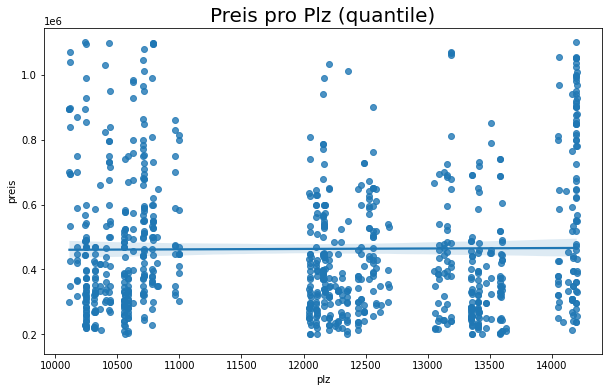

In [102]:
plt.figure(figsize=(10,6))
sns.regplot(x='plz',y='preis',data=df_quant)
plt.ylim(df_quant.preis.min()*.7,)
plt.title('Preis pro Plz (quantile)',fontsize=20)
plt.show()

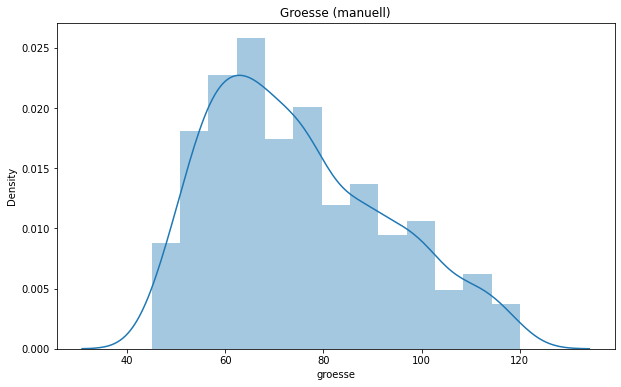

In [103]:
plt.figure(figsize=(10,6))
sns.distplot(df_man['groesse']);
plt.title('Groesse (manuell)')
plt.show()

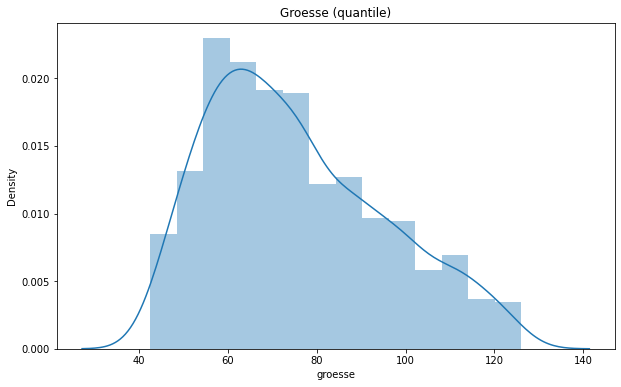

In [104]:
plt.figure(figsize=(10,6))
sns.distplot(df_quant['groesse']);
plt.title('Groesse (quantile)')
plt.show()

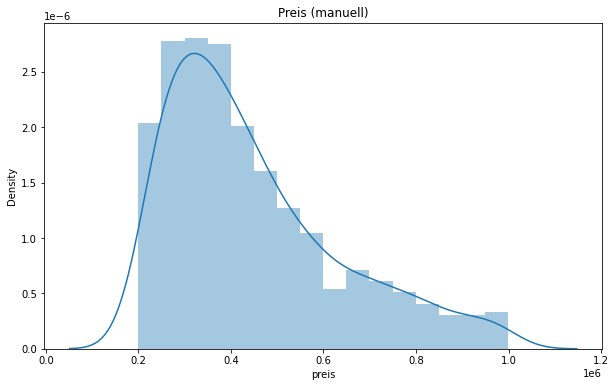

In [105]:
plt.figure(figsize=(10,6))
sns.distplot(df_man['preis']);
plt.title('Preis (manuell)')
plt.show()

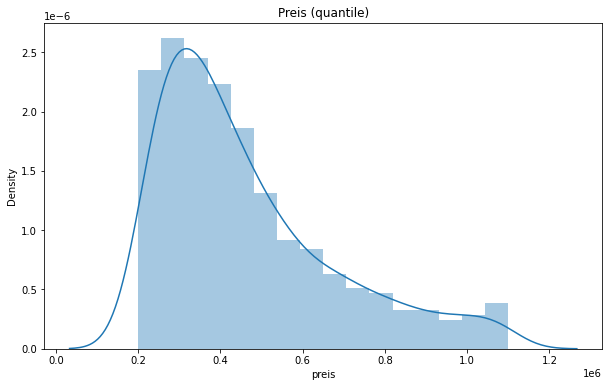

In [106]:
plt.figure(figsize=(10,6))
sns.distplot(df_quant['preis']);
plt.title('Preis (quantile)')
plt.show()

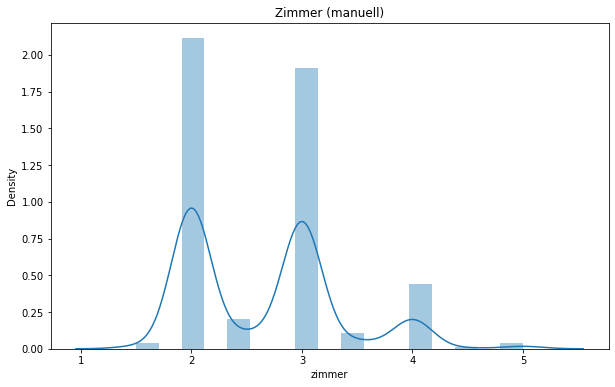

In [107]:
plt.figure(figsize=(10,6))
sns.distplot(df_man['zimmer']);
plt.title('Zimmer (manuell)')
plt.show()

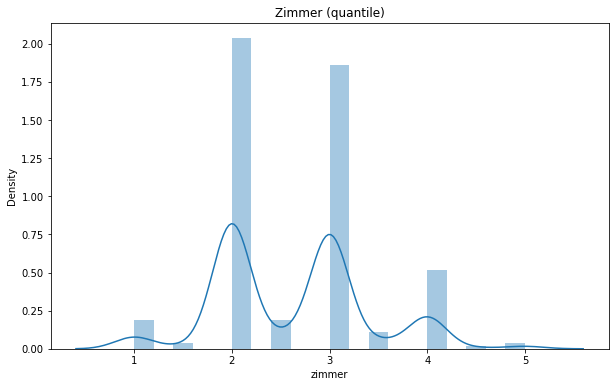

In [108]:
plt.figure(figsize=(10,6))
sns.distplot(df_quant['zimmer']);
plt.title('Zimmer (quantile)')
plt.show()

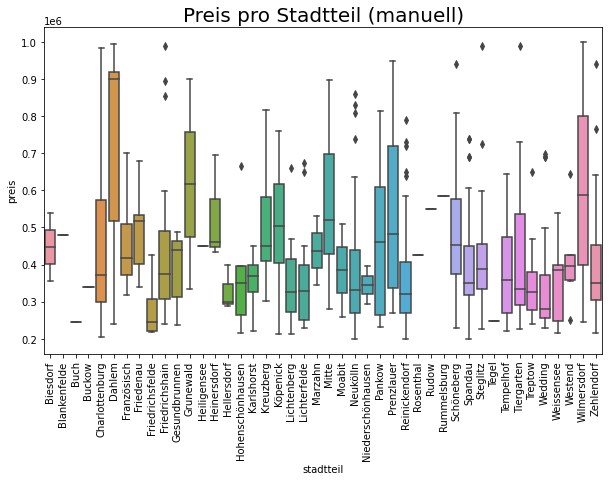

In [109]:
plt.figure(figsize=(10,6))
sns.boxplot(x='stadtteil',y='preis',data=df_man.sort_values('stadtteil'))
plt.xticks(rotation=90)
plt.title('Preis pro Stadtteil (manuell)', fontsize=20)
plt.show()

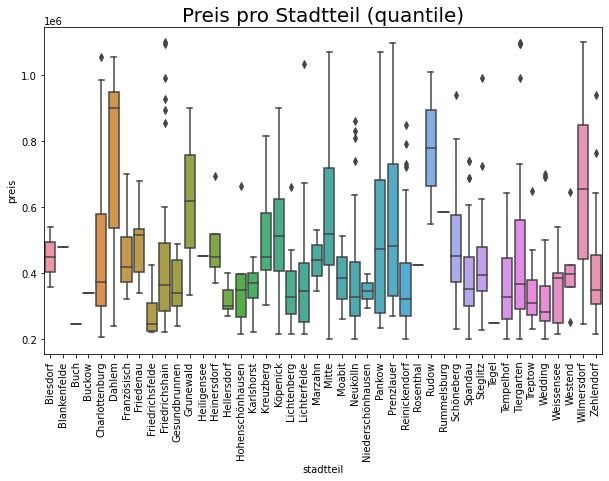

In [110]:
plt.figure(figsize=(10,6))
sns.boxplot(x='stadtteil',y='preis',data=df_quant.sort_values('stadtteil'))
plt.xticks(rotation=90)
plt.title('Preis pro Stadtteil (quantile)', fontsize=20)
plt.show()

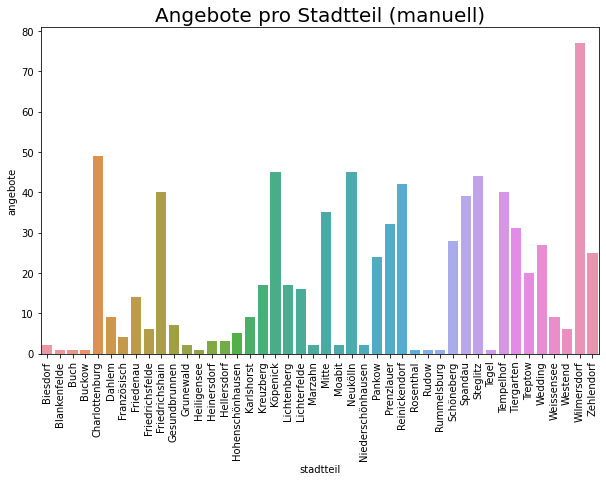

In [111]:
angeb = []
for i in df_man.stadtteil.unique():
    angeb.append((i,df_man.loc[df_man['stadtteil']==i].count().unique()[0])) 
df_ang_man = pd.DataFrame(angeb, columns=['stadtteil','angebote'])
df_ang_man.sort_values('stadtteil', inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x='stadtteil',y='angebote',data=df_ang_man)
plt.xticks(rotation=90)
plt.title('Angebote pro Stadtteil (manuell)', fontsize=20)
plt.show()

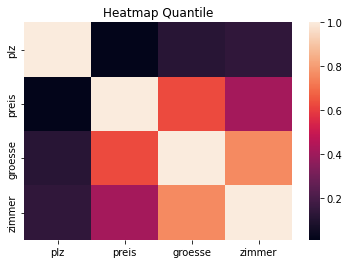

In [112]:
sns.heatmap(df_quant.corr())
plt.title('Heatmap Quantile')
plt.show()

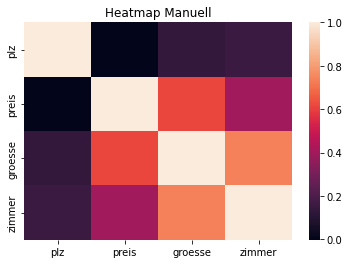

In [113]:
sns.heatmap(df_man.corr())
plt.title('Heatmap Manuell')
plt.show()

DataFrames speichern

In [114]:
df_man.to_csv('df_man.csv', index=False)
df_quant.to_csv('df_quant.csv', index=False)